In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt


In [2]:
RANDOM_SEED = 111
torch.manual_seed(RANDOM_SEED)

In [3]:
# Check for CUDA availability
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda")  # Use the GPU
else:
    print("CUDA Not Available")
    device = torch.device("cpu")   # Use the CPU


CUDA Available


Preparing training data

In [75]:
train_data_length = 1024
# We will use a sin graph as our real data
train_data = torch.zeros((train_data_length, 2)).to(device=device)
# train_data[:, 0] means all rows, 0th column (In here our first column will be x data)
# Random value from 0 to 2pi for x data
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length).to(device=device) # x data
# train_data[:, 1] means all rows, 1st column (In here our second column will be y data)
# torch.sin is the answer to our model
# y is the actual label
train_data[:, 1] = torch.sin(train_data[:, 0]).to(device=device) # y data

# the labels are required by pytorch data loader. But since GAN make use of unsuperivsed learning, we don't need labels
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
print(train_set[0])
print(len(train_set))
print(train_set[0])

(tensor([ 6.0881, -0.1938], device='cuda:0'), tensor(0.))
1024
(tensor([ 6.0881, -0.1938], device='cuda:0'), tensor(0.))


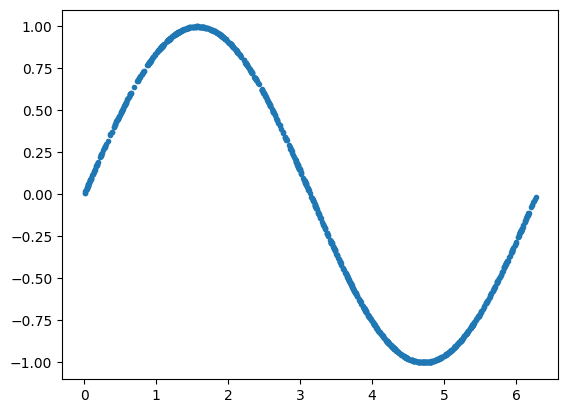

In [5]:
plt.plot(train_data[:, 0].cpu(), train_data[:, 1].cpu(), ".") # we need to use cpu() because we are using cuda

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [79]:
for real, y in train_loader:
    # print(real)
    print(y)
    break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


Implement Discriminator: Discriminator outputs a one-dimensional probability (1 means real, 0 means fake)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        # We use an MLP with 3 hidden layers
        # You can change this to any architecture you want
        # You may use Conv2d as well
        super().__init__()
        self.model = nn.Sequential(
            # 2 input features, 256 output features (hidden layer)
            nn.Linear(2, 256),
            nn.ReLU(),
            # Dropout layer to prevent overfitting
            # the number is the probability of dropping out a neuron
            nn.Dropout(0.3),
            # 256 input features, 128 output features (hidden layer)
            # Since we had 256 hidden features in the previous layer, we need to have 256 input features in this layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            # 128 input features, 64 output features (hidden layer)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            # 64 input features, 1 output features (output layer)
            nn.Linear(64, 1),
            # Since this is a binary classification, we use sigmoid at the end (if it was a multi-class classification, we would use softmax)
            nn.Sigmoid()
        )
    
    # x is the input data
    # in this model the x should have 2 features (x and y)
    # We first train the Discriminator on the real data
    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
discriminator = Discriminator().to(device=device)

Implementing Generator: Generator outputs a fake data that is intended to fool the discriminator

In [69]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
    
    def forward(self, x):
        output = self.model(x)
        return output




In [70]:
generator = Generator().to(device=device)

Train the model.

In [89]:
lr = 0.001 # learning rate
num_epochs = 100 # number of epochs
def backward_hook(grad):
    print(grad)
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)


In [90]:
# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [98]:
count = 0
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        # break

        latent_space_samples = torch.randn((batch_size, 2)).to(device=device)
        # print(latent_space_samples.shape)
        generated_samples = generator(latent_space_samples)
        # break

        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples)).to(device=device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)).to(device=device)


        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Generator

        latent_space_samples = torch.randn((batch_size, 2)).to(device=device)
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        # print(output_discriminator_generated.shape)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        generator.zero_grad()
        # print(loss_generator.shape)
        loss_generator.backward()



        optimizer_generator.step()

        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

print(count)

Epoch: 0 Loss D.: 0.6791531443595886
Epoch: 0 Loss G.: 0.8393402695655823
Epoch: 10 Loss D.: 0.6470686793327332
Epoch: 10 Loss G.: 0.8310157060623169
Epoch: 20 Loss D.: 0.5714586973190308
Epoch: 20 Loss G.: 0.8323227763175964
Epoch: 30 Loss D.: 0.6249933242797852
Epoch: 30 Loss G.: 1.163915753364563
Epoch: 40 Loss D.: 0.6425672769546509
Epoch: 40 Loss G.: 0.7730309367179871
Epoch: 50 Loss D.: 0.6941006183624268
Epoch: 50 Loss G.: 0.6914523839950562
Epoch: 60 Loss D.: 0.6707697510719299
Epoch: 60 Loss G.: 0.8206080198287964
Epoch: 70 Loss D.: 0.604220986366272
Epoch: 70 Loss G.: 0.7990505695343018
Epoch: 80 Loss D.: 0.5487982034683228
Epoch: 80 Loss G.: 1.4084216356277466
Epoch: 90 Loss D.: 0.5724806785583496
Epoch: 90 Loss G.: 1.0265408754348755
0


Checking the samples generated by GAN

In [94]:
latent_space_samples = torch.randn(100, 2).to(device=device)

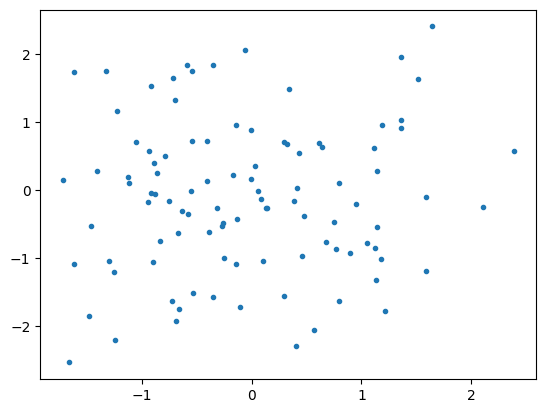

In [95]:
plt.plot(latent_space_samples[:, 0].cpu(), latent_space_samples[:, 1].cpu(), ".")

In [96]:
# Now our trained generator will generate 100 samples that are able to fool the discriminator
generated_samples = generator(latent_space_samples)

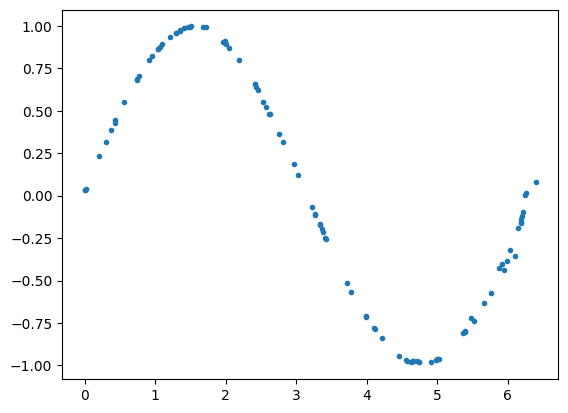

In [97]:
generated_samples = generated_samples.cpu().detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [79]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [82]:
print("Model's state_dict:")
for param_tensor in generator.state_dict():
    print(param_tensor, "\t", generator.state_dict()[param_tensor].size())


Model's state_dict:
model.0.weight 	 torch.Size([16, 2])
model.0.bias 	 torch.Size([16])
model.2.weight 	 torch.Size([32, 16])
model.2.bias 	 torch.Size([32])
model.4.weight 	 torch.Size([2, 32])
model.4.bias 	 torch.Size([2])


In [84]:
print("Discriminators's state_dict:")
for var_name in discriminator.state_dict():
    print(var_name, "\t", discriminator.state_dict()[var_name])

Discriminators's state_dict:
model.0.weight 	 tensor([[-3.5760e-02,  4.5280e-01],
        [-8.9726e-02, -4.5776e-01],
        [-6.2699e-01, -5.9596e-01],
        [-4.9961e-02, -2.3550e-01],
        [-6.5236e-02, -3.0417e-01],
        [-1.6678e-01, -2.1080e-01],
        [ 2.7048e-01,  3.0472e-01],
        [-5.2899e-02,  3.6164e-01],
        [-4.6010e-01, -6.2679e-02],
        [-1.0161e-01, -1.4337e-01],
        [ 2.3149e-01,  2.8756e-01],
        [ 8.7188e-02,  3.1755e-01],
        [ 3.5521e-01,  4.0270e-01],
        [ 1.5219e-01,  4.2221e-01],
        [-2.7809e-01, -2.7873e-01],
        [-6.1134e-02, -1.8589e-01],
        [-6.3376e-01,  1.4190e-01],
        [-4.3821e-01,  4.7709e-01],
        [-2.0062e-02,  1.2642e-01],
        [ 4.5879e-02, -7.1656e-01],
        [-2.4399e-01,  9.7048e-02],
        [-6.2367e-02, -5.4352e-01],
        [ 3.9039e-01,  4.2150e-01],
        [-5.2037e-01, -1.1993e-01],
        [-6.3809e-01,  3.5008e-01],
        [ 2.9128e-01,  2.4697e-01],
        [-1.8931e-